In [2]:
%matplotlib inline

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)
df = pd.read_csv('data/Consumo_cerveja.csv', 
                 decimal=',', 
                 thousands='.', 
                 header=0, 
                 names=['date','median_temp','min_temp','max_temp','precip','weekend','consumption'], 
                 parse_dates=['date'], 
                 nrows=365)
df = df.set_index('date')

# Let's start asking questions

Now we've gone through a number of techniques for working with data in Pandas - let's try applying some of these to answer some questions about our data - remember, we are interested in learning about factors that affect beer consumption in Sao Paulo!

So what kind of questions can we ask of our data?

## Does temperature matter in beer consumption?
We would hypothesize that when it's warmer outside, people go out for a drink more often. However, as we know from here in Denmark, Danes often grab a beer inside a nice, warm bar when it's cold and dark!

## Do people drink more beer in the weekend?
From collective personal experience, we would assume that consumption is higher during the weekend.

## Is there seasonality in beer drinking?
Are people drinking more beer in autumn vs winter?

## Does day of the week matter?
Does the weekend start on Friday? Or maybe people need a beer on Monday to help them start the week?

## Does precipitation affect beer drinking?
Does more rain lead to less beer drinking? Or do people stay inside the bars longer?

## Are weekends different when it comes to weather?
It feels like the weather is worse when we have time off, no?

# Correlations
We can always start with a simple correlation matrix - this is easy to get in Pandas!

In [20]:
df.corr()

,median_temp,min_temp,max_temp,precip,weekend,consumption
median_temp,1.000000,0.862752,0.922513,0.024416,-0.050803,0.574615
min_temp,0.862752,1.000000,0.672929,0.098625,-0.059534,0.392509
max_temp,0.922513,0.672929,1.000000,-0.049305,-0.040258,0.642672
precip,0.024416,0.098625,-0.049305,1.000000,0.001587,-0.193784
weekend,-0.050803,-0.059534,-0.040258,0.001587,1.000000,0.505981
consumption,0.574615,0.392509,0.642672,-0.193784,0.505981,1.000000


It's a bit hard to parse just by looking - we could use seaborn to draw a heatmap, but we are sticking as much as we can to Pandas. Let's use the new `.style` api!

In [21]:
df.corr().style.background_gradient()

,median_temp,min_temp,max_temp,precip,weekend,consumption
median_temp,1,0.862752,0.922513,0.0244158,-0.050803,0.574615
min_temp,0.862752,1,0.672929,0.0986255,-0.0595337,0.392509
max_temp,0.922513,0.672929,1,-0.0493052,-0.0402584,0.642672
precip,0.0244158,0.0986255,-0.0493052,1,0.00158677,-0.193784
weekend,-0.050803,-0.0595337,-0.0402584,0.00158677,1,0.505981
consumption,0.574615,0.392509,0.642672,-0.193784,0.505981,1


In [14]:
df.corr()[['consumption']].style.bar(align='mid', color=['red', 'green'])

,consumption
median_temp,0.574615
min_temp,0.392509
max_temp,0.642672
precip,-0.193784
weekend,0.505981
consumption,1


We see some evidence to back up our hypotheses - temperature and weekend appears correllated with consumption, while precipiation is slightly negatively correlated.

![Fun Fact](images/fun_fact.resized.jpeg)Before we dive in a bit more, just want to mention one technique that's very useful - I've been using it throughout, but now we'll give it a name:

# Method Chaining

One neat feature of the pandas api is that many operations return a modified DataFrame/Series. This means that we can continue to apply operations in a chain, making it simple and readable to transform data. My favorite example of the difference this makes is stolen from [Tom Augspurg](https://tomaugspurger.github.io/method-chaining) (who stole it from [Jeff Allen](https://trestletech.com/wp-content/uploads/2015/07/dplyr.pdf)). Imagine we are telling the story of Jack and Jill - traditionally it would look like this:

```python
tumble_after(
    broke(
        fell_down(
            fetch(went_up(jack_jill, "hill"), "water"),
            jack),
        "crown"),
    "jill"
)
```

What's the story happening here?
You might be a clever software engineer and rewrite it to something like this:
```python
on_hill = went_up(jack_jill, 'hill')
with_water = fetch(on_hill, 'water')
fallen = fell_down(with_water, 'jack')
broken = broke(fallen, 'jack')
after = tumble_after(broken, 'jill')
```

That looks better, but now I had to come up with 5 sensible variable names that are essentially thrown out - and it's not even that clear what the story is!

Pandas let's us do something like this:
```python
(jack_jill.went_up('hill')
    .fetch('water')
    .fell_down('jack')
    .broke('crown')
    .tumble_after('jill')
)
```

That's the best of both worlds! I can clearly read the story, while at the same time, avoiding the need for "throwaway" variable names

Now back to the data!

![Plot](images/plot_all_the_things.jpg)

In the EDA phase, we just want to plot everything, but we are not looking at production grade plots - we want quick and dirty with features - pandas has you covered!
Let's start by plotting each column over time

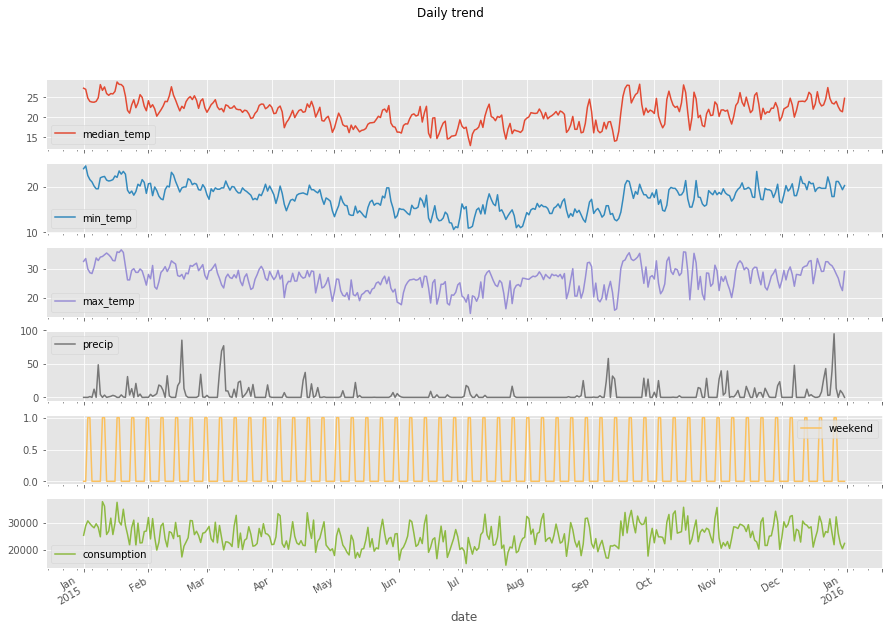

In [24]:
df.plot(subplots=True, title='Daily trend');

That's a bit hard to parse - There are definitely some seasonal trends in the precipitation, but it's hard to get a clear picture of what's happening. Weekend is also not very useful in this context

Let's use some of the techniques we looked at to capture a higher-level trend

In [32]:
numeric = df.drop('weekend',axis='columns')

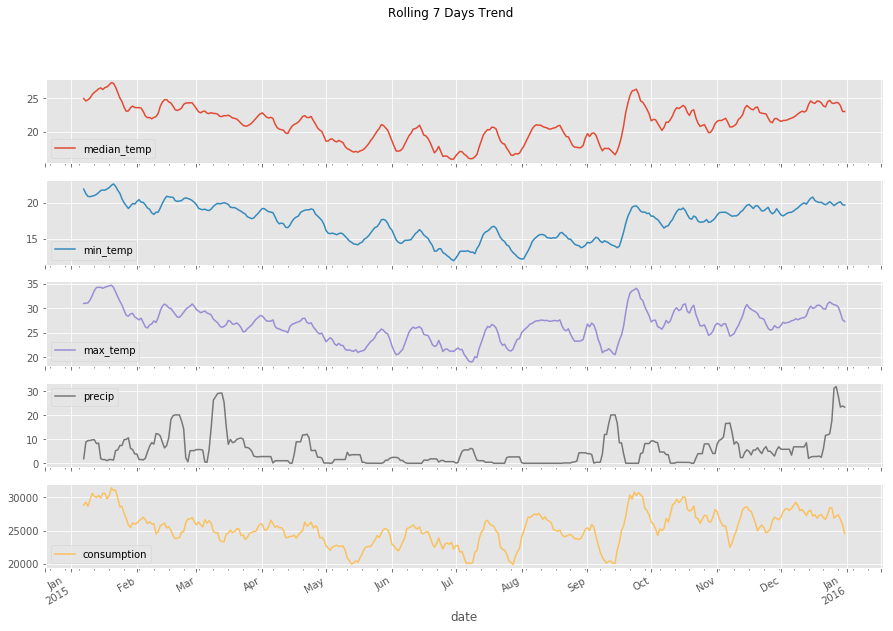

In [42]:
rolling = numeric.rolling(7)
axes = rolling.mean().plot(subplots=True, title='Rolling 7 Days Trend');

The correlation between temperature and consumption is now more obvious - we also see that the big increase in precipitation around March does not significantly impact consumption, but in mid September, consumption is very low. Let's try to smooth it out even more by looking at monthly data.

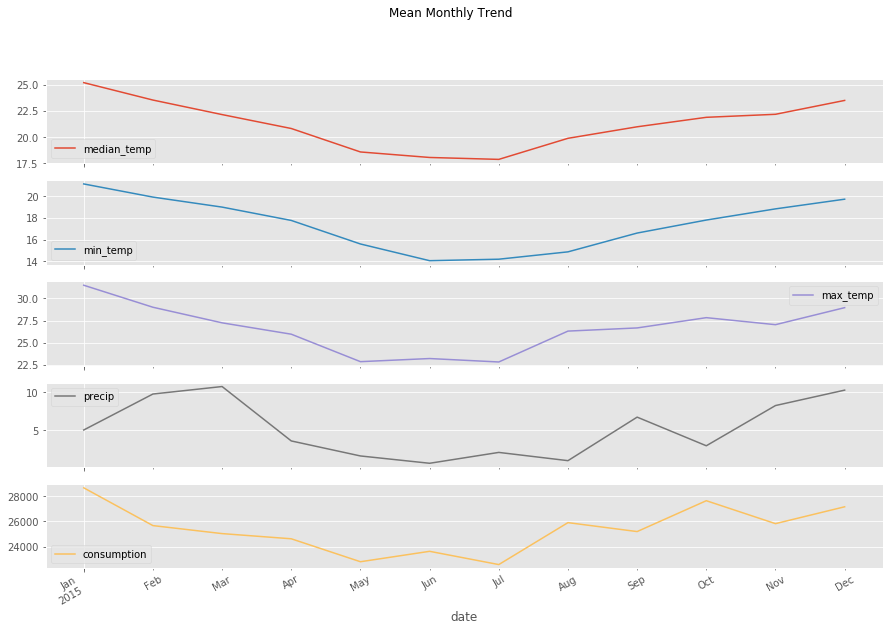

In [39]:
resampler = numeric.resample('M')
resampler.mean().plot(subplots=True, title='Mean Monthly Trend');

There is now a clear trend between temperature and consumption but we lost some knowledge. For example, the inverse relationship with preciptiation in mid-september is not as clear as in the rolling 7 graph. Always use different aggregation levels!

Let's start trying to answer our questions about the data:

## Does temperature matter in beer consumption?
Looking at our trend over time graphs above, we would conclude that yes, the temperature clearly affects consumption (It would be difficult to make the argument that consumption affects temperature!)

Let's examine the relationship a bit more using a scatterplot. Scatterplots are a great way to visualize numerical relationships - we lose the time dimension, but are able to see the correlation better.

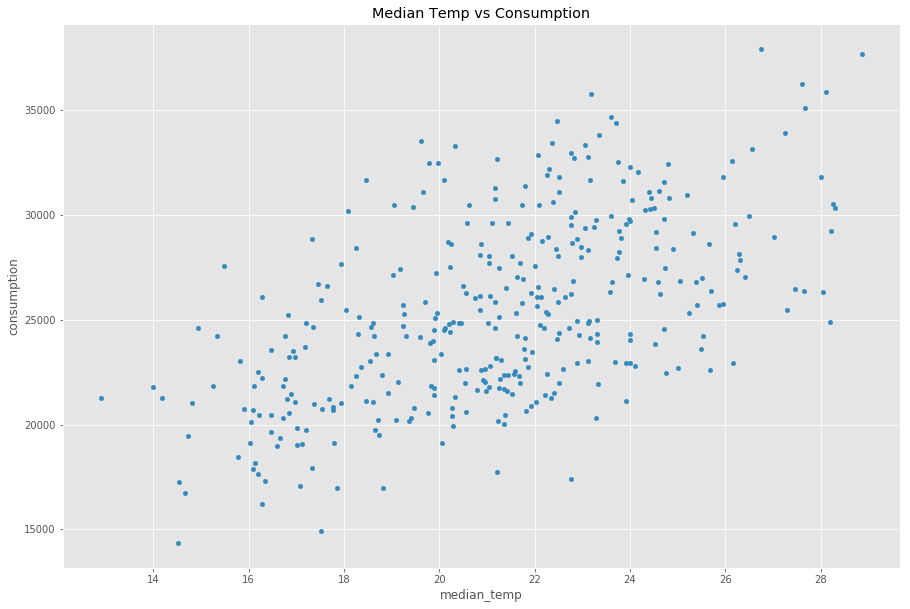

In [55]:
df.plot.scatter(x='median_temp', y='consumption', title='Median Temp vs Consumption');

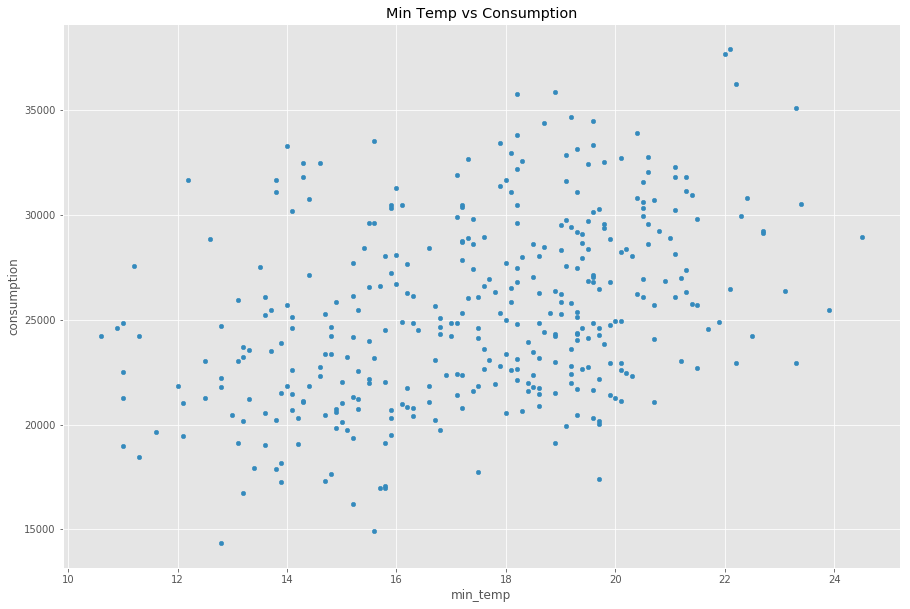

In [57]:
df.plot.scatter(x='min_temp', y='consumption', title='Min Temp vs Consumption');

These two graphs are a bit hard to compare as they have different x axes. Just for illustration purposes, let's plot them on the same graph

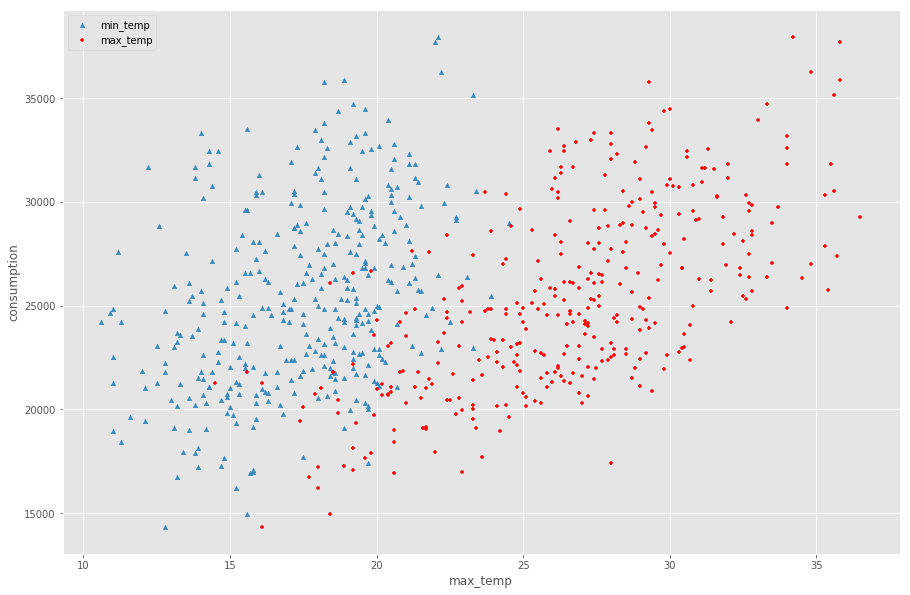

In [72]:
ax = df.plot(kind='scatter', x='min_temp', y='consumption', marker='^', label='min_temp');
df.plot(kind='scatter', x='max_temp', y='consumption', c='red', marker='+', ax=ax, label='max_temp');

Min_temp and max_temp are clearly different- Surprising! :-) It would be more clear if we could plot them each in their own graph, but keep the y axis scale. We could adjust them manually, but it's better to have that done for us! That does require some matplotlib code though - knowing some matplotlib is very helpful to get plots the way you want them!

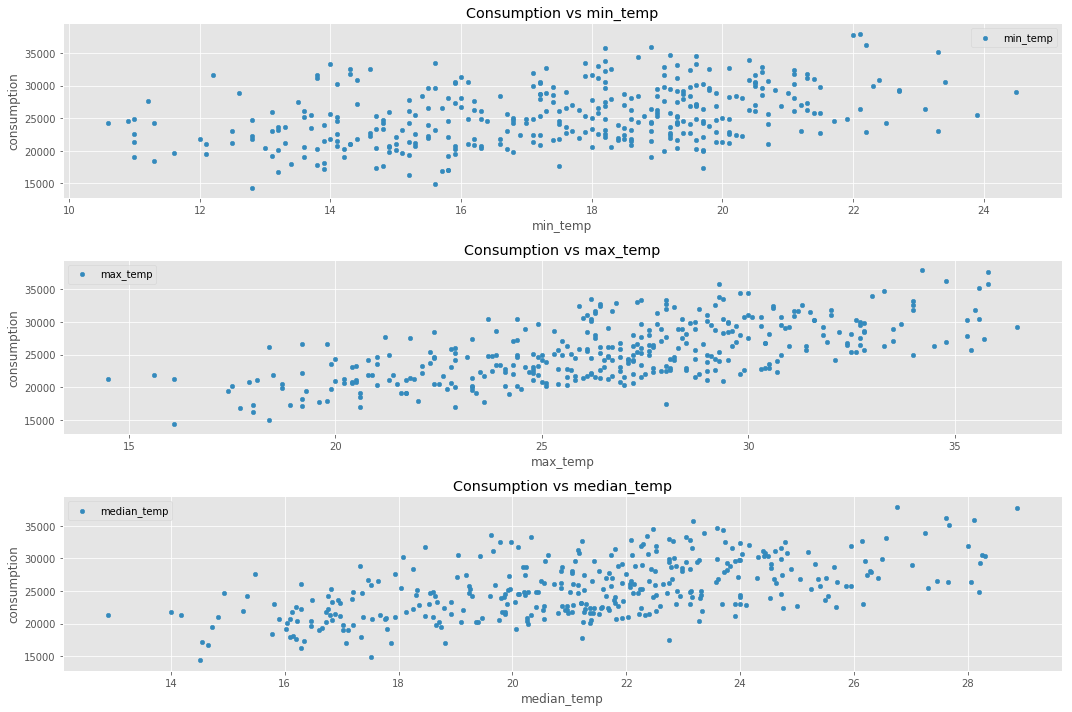

In [71]:
fig, axes = plt.subplots(nrows=3, sharey=True)
for label, ax in zip(['min_temp', 'max_temp', 'median_temp'], axes):
    df.plot.scatter(x=label, y='consumption', ax=ax, label=label, title=f"Consumption vs {label}")
fig.tight_layout()

Looks a lot like our line graphs before! Just looking at the graphs - max_temp seems a bit more clustered around an imaginary trend line while min_temp is fairly spaced out. Let's note that max_temp does seem be a more linear predictor than the other two.

We can confirm this by looking at the mean consumption per 5 degrees

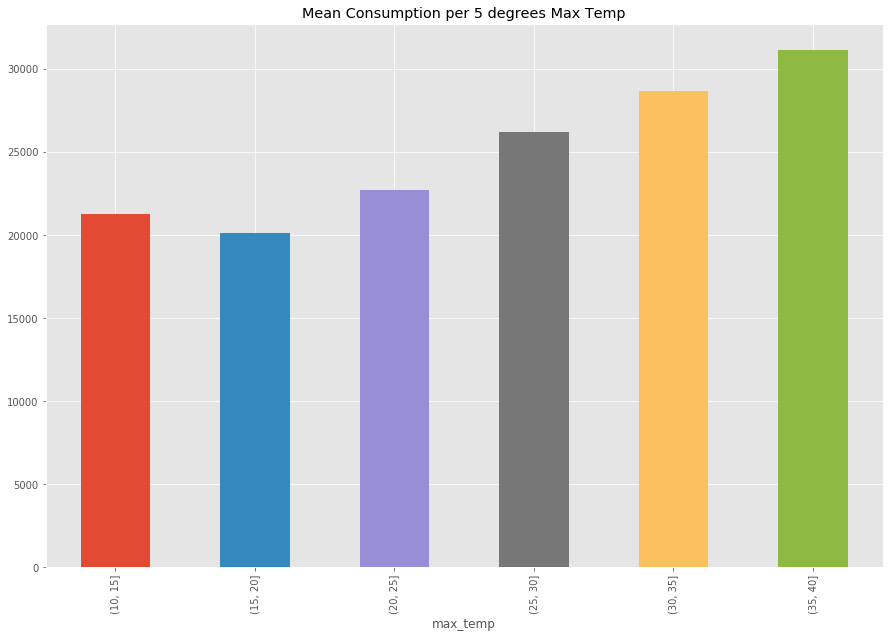

In [99]:
df.groupby(pd.cut(df.max_temp, np.arange(10, 45, 5))).consumption.mean().plot.bar(title='Mean Consumption per 5 degrees Max Temp');

I think we can conclusively say temperature matters!

# Do people drink more beer in the weekend?
This is a pretty easy question to answer - we simply take the mean of weekends vs mean of non-weekends!

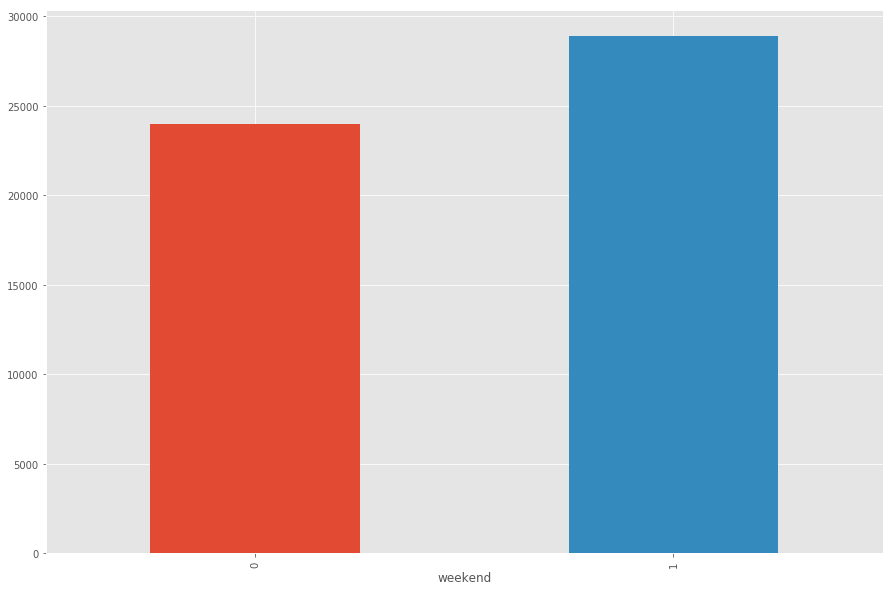

In [100]:
df.groupby('weekend').consumption.mean().plot(kind='bar');

That seems pretty conclusive! We can also examine the distribution of values using a boxplot 

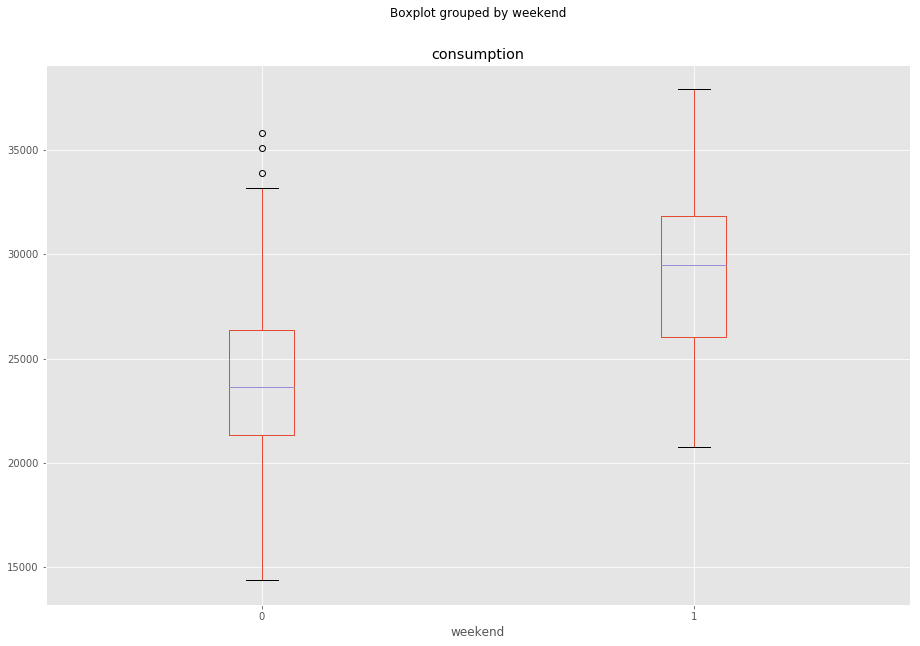

In [9]:
df.boxplot(column='consumption', by='weekend')

We must be careful with averages! While there is a clear difference, there are a fair number of weekdays where consumption is at weekend levels.

In [112]:
weekend_mean = df.query('weekend == 1').consumption.mean()

num_above_mean_weekdays = len(df[(df.weekend == 0) & (df.consumption > weekend_mean)])
print(f"There are {num_above_mean_weekdays} weekdays above the weekend mean")
print(f"That's {num_above_mean_weekdays / len(df.weekend == 0):.1%}!")

There are 29 weekdays above the weekend mean
That's 7.9%!


Almost 8% of our weekdays would look like a weekend if we trusted our average! We can conclude that being the weekend is definitely related to consumption - but always examine the distributions!

# Does seasonality affect consumption?
Seasons can have an impact in many different ways - holidays, number of tourists and of course the weather! Unfortunately we only have one year of data, so it will be hard to estimate these effects in a robust manner - but we can 

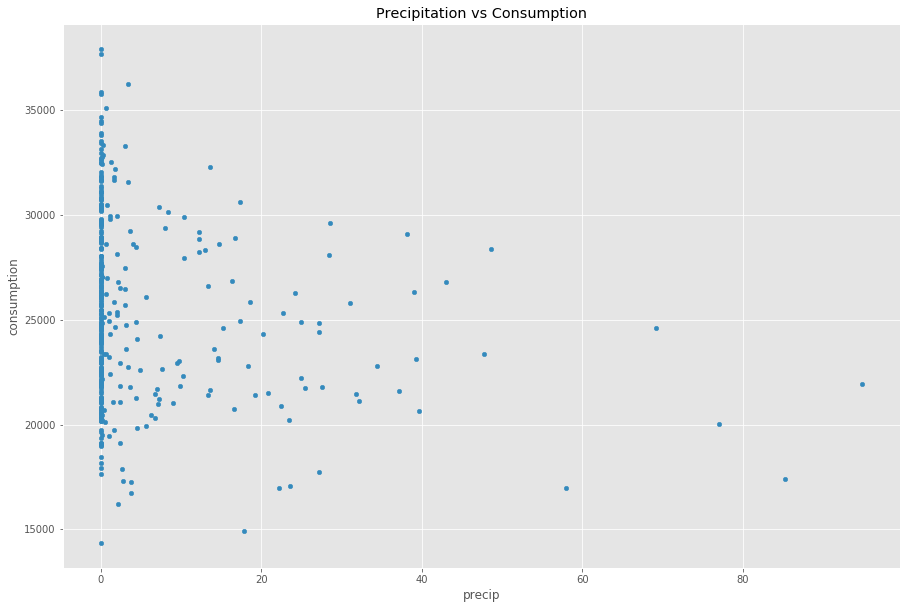

In [46]:
df.plot(kind='scatter', x='precip', y='consumption', title='Precipitation vs Consumption');

We don't see a nice linear trend, but this is also affected by many days with close to zero rain - lucky Brazilians!

We can try to get a bit fancy - let's logtransform `precip` and see if that makes a difference. Here we are using method chaining to get a nice story out of our transforms

![Fun Fact](images/fun_fact.resized.jpeg) If we wrap our method chain in `()` we can align each operation nicely on a new line!

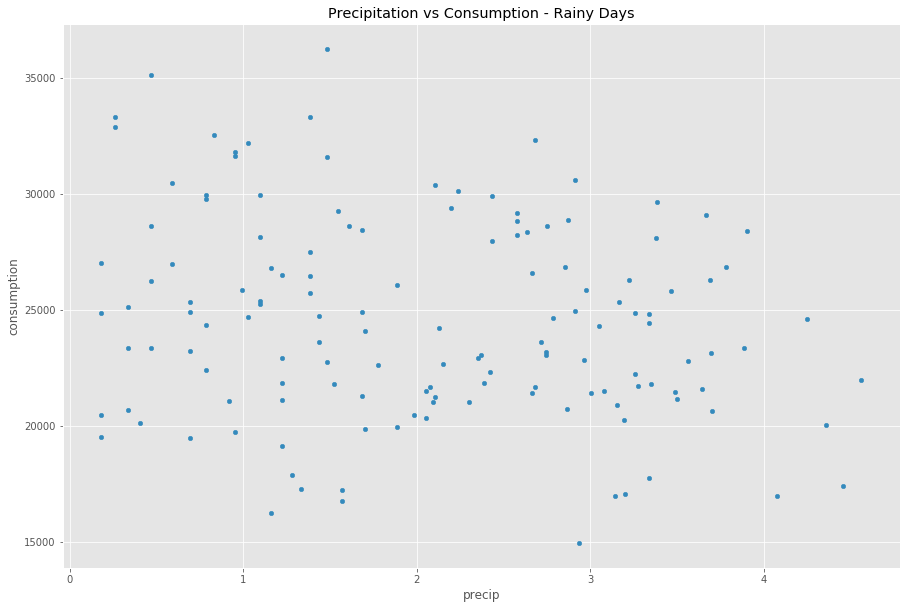

In [51]:
(df.assign(precip=lambda x: np.log1p(x.precip))
 .query('precip > 0.1')
 .plot(kind='scatter', x='precip', y='consumption', title='Precipitation vs Consumption - Rainy Days'))

Looks like we don't get any 

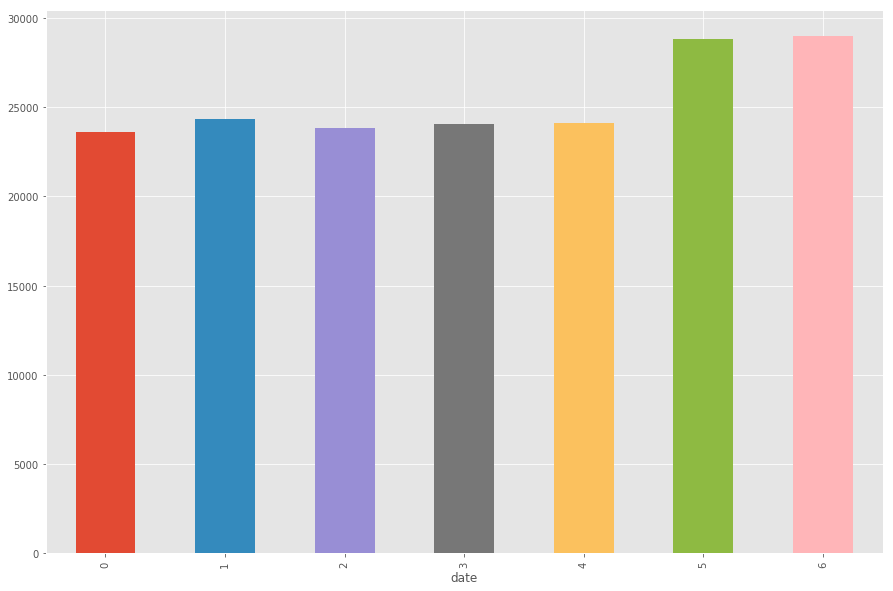

In [10]:
df.groupby(df.date.dt.weekday).consumption.mean().plot(kind='bar')

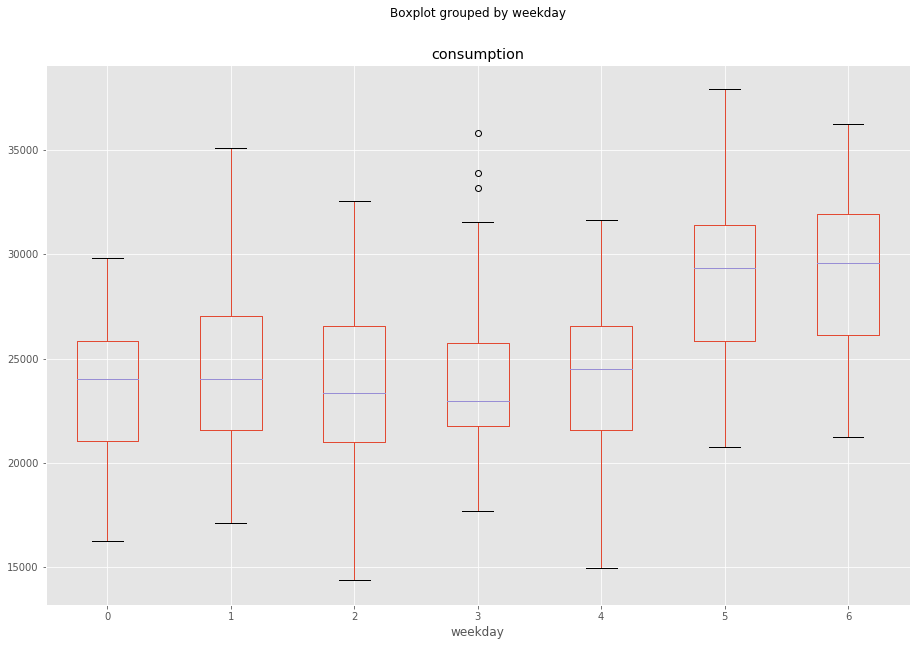

In [11]:
df['weekday'] = df.date.dt.weekday
df.boxplot(column='consumption', by='weekday')

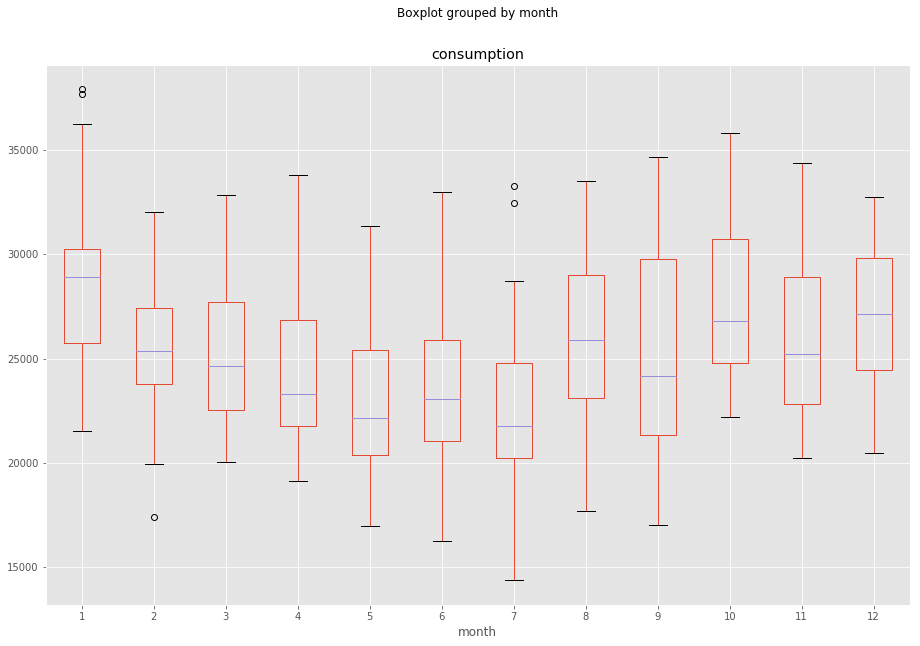

In [13]:
df['month'] = df.date.dt.month
df.boxplot(column='consumption', by='month')

In [14]:
pivoted = df.pivot_table(values='consumption', index='weekday', columns='month')
pivoted

month,1,2,3,4,5,6,7,8,9,10,11,12
weekday,,,,,,,,,,,,
0,26357.00,24798.50,23384.80,22779.50,22355.25,21876.40,20920.75,24648.00,22062.75,25753.00,23122.60,25608.75
1,30076.75,24287.50,24001.00,23731.25,21813.75,21953.80,21659.75,24017.25,24143.00,26070.00,24839.50,25999.20
2,28322.50,24575.25,22122.25,21536.80,20437.50,21050.50,21256.00,24002.75,24724.80,28280.75,24945.25,25121.00
3,25614.60,23011.25,26081.50,21559.80,21228.00,22846.00,21094.20,21070.00,27505.50,27481.20,25161.50,25938.60
4,26485.00,24462.00,23280.50,23927.50,19659.40,21531.25,21700.00,24379.75,24130.25,27393.40,24633.25,28400.75
5,32363.80,29133.50,29081.25,31299.25,25530.00,27004.50,24222.00,31051.20,26278.50,30862.00,28985.00,29130.25
6,31916.25,29444.00,27387.40,29072.50,27493.00,29983.00,28074.50,30160.60,27924.25,27037.75,28995.00,31100.50


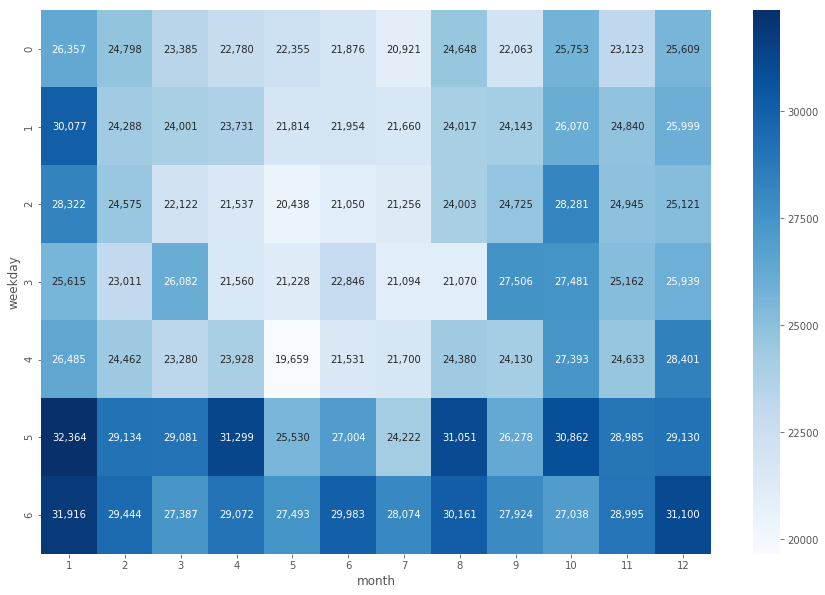

In [17]:
sns.heatmap(pivoted, annot=True, fmt=',.0f', cmap='Blues')